/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 157MB/s]


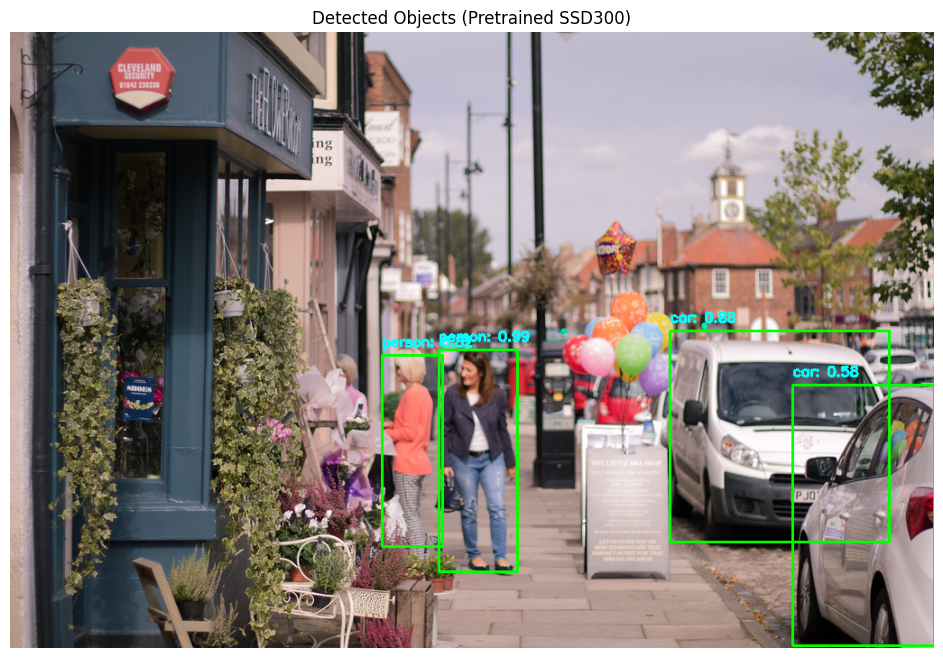

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import ssd300_vgg16
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import requests

# COCO class labels (used by SSD, 1-based indexing)
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter',
    'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
    'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
    'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
    'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog',
    'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table',
    'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Load pretrained SSD300 VGG16 model
model = ssd300_vgg16(pretrained=True)
model.eval()  # Set to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load and preprocess image (use URL or local path)
img_url = 'https://live.staticflickr.com/8498/28974678683_692a7d452a_b.jpg'  # Replace with your image URL or path
try:
    response = requests.get(img_url, stream=True)
    img = Image.open(response.raw).convert("RGB")
except Exception as e:
    print(f"Failed to load image from URL: {e}")
    # Fallback to a local image
    img_path = 'path/to/local/image.jpg'  # Replace with your local image path
    img = Image.open(img_path).convert("RGB")

# Get original image dimensions
orig_width, orig_height = img.size
model_input_size = 300  # SSD300 input size (300x300)

# Preprocess image for model
input_tensor = transform(img).unsqueeze(0).to(device)

# Run inference
with torch.no_grad():
    outputs = model(input_tensor)

# Process detections
threshold = 0.5
output = outputs[0]
boxes = output['boxes'].cpu()
labels = output['labels'].cpu()
scores = output['scores'].cpu()

# Draw results on original image
img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Scale bounding boxes to original image dimensions
for box, label, score in zip(boxes, labels, scores):
    if score > threshold and COCO_INSTANCE_CATEGORY_NAMES[label] in ['car', 'person', 'truck', 'traffic light']:
        x1, y1, x2, y2 = box
        # Scale coordinates
        x1 = int(x1 * orig_width / model_input_size)
        y1 = int(y1 * orig_height / model_input_size)
        x2 = int(x2 * orig_width / model_input_size)
        y2 = int(y2 * orig_height / model_input_size)
        # Draw rectangle and label
        cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(img_cv, f"{COCO_INSTANCE_CATEGORY_NAMES[label]}: {score:.2f}",
                    (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

# Display result
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Detected Objects (Pretrained SSD300)")
plt.show()